In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl
from openpyxl import load_workbook
import os
#from ccfj import GetStationPairs
from geopy.distance import great_circle
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
#import shapefile
import geopandas as gp
import yaml
import math
#from pykml import parser


In [2]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import plotlib
from toollib_standard import mathlib

In [3]:
flag_project = 1 # 0--regular; 1--repartrition

In [4]:
if flag_project == 0:
    file_project = 'a-project.yml'
elif flag_project == 1:
    file_project = 'a-project_repar.yml'
elif flag_project == 2:
    file_project = 'a-project_voro.yml'
    
with open(file_project, 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']

#name_project = 'project/output_FJSJ_16-01/'               
#name_project = 'project_repartrition/repartrition_01-03/'               
#name_project = 'project_voronoi/voronoi_01-03/'         

In [5]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v4.0/output_repar_v9.5_01--10-16Hz/


In [6]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [7]:
dir_image = dir_project + info_basic['rdir_image']+'phase/'
if not os.path.exists(dir_image):
    os.makedirs(dir_image)
dir_partition = dir_project + info_basic['rdir_partition']
dir_disp = dir_project + info_basic['rdir_disp_model']
key_subworks = info_basic['key_subworks']
M = len(key_subworks)
key_subworks

['1--08-03',
 '2--09-03',
 '3--10-03',
 '4--11-03',
 '5--12-03',
 '6--13-03',
 '7--14-03',
 '8--15-03',
 '9--16-03',
 '10--18-03',
 '12--20-03',
 '13--21-03',
 '15--23-03',
 '17--25-03',
 '18--26-03',
 '19--27-03',
 '20--28-03',
 '21--29-03',
 '22--30-03',
 '23--31-03',
 '28--36-03',
 '30--41-03',
 '31--42-03',
 '34--47-03',
 '35--48-03',
 '36--52-03',
 '37--53-03',
 '38--07-04',
 '39--08-04',
 '40--09-04',
 '41--10-04',
 '42--12-04',
 '43--13-04',
 '44--17-04',
 '45--20-04',
 '46--21-04',
 '48--23-04',
 '49--24-04',
 '50--25-04',
 '51--27-04',
 '52--28-04',
 '53--29-04',
 '54--30-04',
 '55--31-04',
 '56--32-04',
 '57--33-04',
 '58--34-04',
 '60--36-04',
 '63--47-04',
 '65--49-04',
 '67--53-04',
 '68--08-05',
 '69--12-05',
 '70--13-05',
 '71--14-05',
 '72--16-05',
 '75--22-05',
 '76--24-05',
 '77--26-05',
 '78--27-05',
 '79--28-05',
 '80--29-05',
 '81--30-05',
 '85--36-05',
 '86--37-05',
 '88--39-05',
 '89--40-05',
 '91--42-05',
 '93--44-05',
 '98--53-05',
 '99--54-05',
 '100--07-06',


In [8]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = mathlib.GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist() 
lat_all =  stainfo['latitude'].tolist() 
lon_all =  stainfo['longitude'].tolist() 

In [9]:
stations = {}
lat = {}
lon = {}
for key in key_subworks:
    filepath = dir_partition + str(key) + '.txt'
    stations_this, lat_stations_this, lon_stations_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations[key] = stations_this
    lat[key] = lat_stations_this.astype(float)
    lon[key] = lon_stations_this.astype(float)

In [10]:
num_stations = []
for key_subwork in key_subworks:
    num_stations.append(len(stations[key_subwork]))

In [11]:
#key_subworks = info_basic['key_subworks']
lat_centroid = []
lon_centroid = []
for key_subwork in key_subworks:
    lon_centroid.append(np.mean(lon[key_subwork]))
    lat_centroid.append(np.mean(lat[key_subwork]))

In [12]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

In [13]:
#f_list = [3,3.5,4,4.5,5,10,15,20]
f_list = [4,5,7,10,20]
phase = {}
for f in f_list:
    phase[f] = []
for key in key_subworks:
    disp = np.loadtxt(dir_disp + 'disp_model_'+key+'.txt')
    disp = disp[disp[:,2] == 0]
    for f in f_list:
        phase[f].append(disp[disp[:,0]==f][0][1])

In [14]:
size_range = [20,30]
num_range = [np.min(num_stations),np.max(num_stations)]
#将num_stations归一化到size_range
size = []
for num in num_stations:
    size.append(size_range[0]+(size_range[1]-size_range[0])*(num-num_range[0])/(num_range[1]-num_range[0]))

In [15]:
"""
#ig,ax = plt.subplots(2,3,figsize=(15,8))
flag_this = 0
c_min = 0.4
c_max = 1.2
flag_num = 1
fig = plt.figure(figsize=(15,6))
for f in f_list:
    
    ax = plt.subplot(1,2,flag_num)

    ax.scatter(lon_all, lat_all,marker='.',color='k',s=1)
    im = ax.scatter(lon_centroid, lat_centroid,c=phase[f],cmap='jet',s=size)
    #im = ax[0][flag_this].scatter(lon_centroid, lat_centroid,c=phase[f],cmap='jet',s=200,vmin = c_min,vmax = c_max)
    plt.colorbar(im,ax=ax)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Phase Velocity at f = '+str(f)+' Hz (km/s)')
    ax.set_xticks([])
    ax.set_yticks([])
    for i in range(len(faults)):
        ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')


    flag_num += 1
plt.tight_layout()
print(dir_image+'phase_compare_'+str(f_list[0])+'_'+str(f_list[1])+'.png')
plt.savefig(dir_image+'phase_compare_'+str(f_list[0])+'_'+str(f_list[1])+'.png',dpi=300)
"""

"\n#ig,ax = plt.subplots(2,3,figsize=(15,8))\nflag_this = 0\nc_min = 0.4\nc_max = 1.2\nflag_num = 1\nfig = plt.figure(figsize=(15,6))\nfor f in f_list:\n    \n    ax = plt.subplot(1,2,flag_num)\n\n    ax.scatter(lon_all, lat_all,marker='.',color='k',s=1)\n    im = ax.scatter(lon_centroid, lat_centroid,c=phase[f],cmap='jet',s=size)\n    #im = ax[0][flag_this].scatter(lon_centroid, lat_centroid,c=phase[f],cmap='jet',s=200,vmin = c_min,vmax = c_max)\n    plt.colorbar(im,ax=ax)\n    ax.set_xlabel('Longitude')\n    ax.set_ylabel('Latitude')\n    ax.set_title('Phase Velocity at f = '+str(f)+' Hz (km/s)')\n    ax.set_xticks([])\n    ax.set_yticks([])\n    for i in range(len(faults)):\n        ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')\n\n\n    flag_num += 1\nplt.tight_layout()\nprint(dir_image+'phase_compare_'+str(f_list[0])+'_'+str(f_list[1])+'.png')\nplt.savefig(dir_image+'phase_compare_'+str(f_list[0])+'_'+str(f_list[1])+'.png',dpi=300)\n"

/shdisk/rem2/Harmon/F-J/San/project_repartition_v4.0/output_repar_v9.5_01--10-16Hz/image_v9.5_01--10-16Hz/phase/phase_compare.png


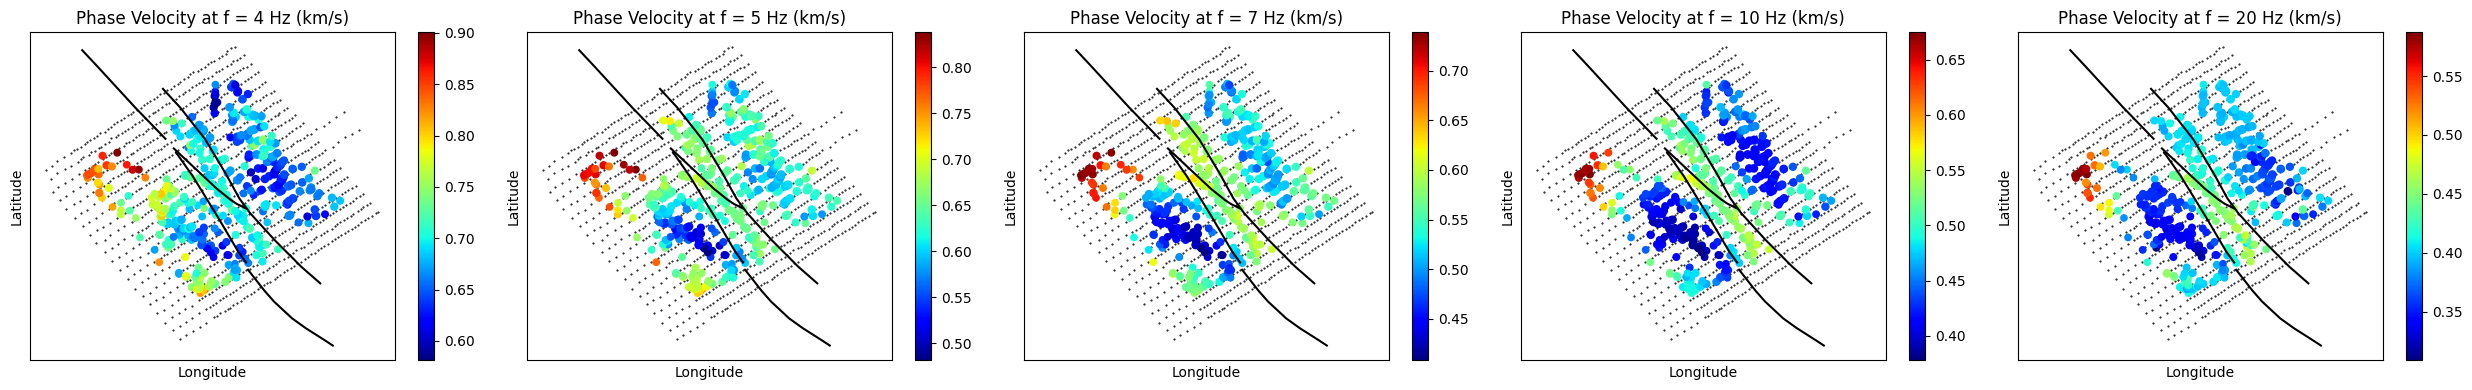

In [16]:
flag_this = 0
c_min = 0.4
c_max = 1.2
flag_num = 1
fig = plt.figure(figsize=(5*len(f_list),4))
for f in f_list:
    
    ax = plt.subplot(1,len(f_list),flag_num)

    ax.scatter(lon_all, lat_all,marker='.',color='k',s=1)
    im = ax.scatter(lon_centroid, lat_centroid,c=phase[f],cmap='jet',s=size)
    #im = ax[0][flag_this].scatter(lon_centroid, lat_centroid,c=phase[f],cmap='jet',s=200,vmin = c_min,vmax = c_max)
    plt.colorbar(im,ax=ax)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Phase Velocity at f = '+str(f)+' Hz (km/s)')
    ax.set_xticks([])
    ax.set_yticks([])
    for i in range(len(faults)):
        ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')


    flag_num += 1
plt.tight_layout()
print(dir_image+'phase_compare.png')
plt.savefig(dir_image+'phase_compare_2.png',dpi=300)